In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis
import standard_sequences.ramsey as ramsey
import standard_sequences.pinopi as pnp

In [2]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"

bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)


In [3]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(mixer_offset_ef=6, ro_dur=5000, qubit_thr=[-10000, -600], ROIF=0.1026600000000002, ge_ssm=-0.117, ef_half_time=25, RO_LO_pwr=16, ge_time=77, IQ_angle=60, qubit_id=q1, ef_amp=1.5, RO_LO_34=6.4804, RO_LO_45=6.3804, mixer_offset_ge=2.5, ef_half_amp=1.3, RO_LO=6.6247, ro_freq=6.72736, ro_amp=0.5, RO_IF=None, ge_amp=1, ef_time=44, ef_ssm=-0.25684)
Qubit(mixer_offset_ef=None, ro_dur=5000, qubit_thr=[-10000, 1900], ROIF=0.030700000000000394, ge_ssm=-0.155, ef_half_time=None, RO_LO_pwr=16, ge_time=62, IQ_angle=25, qubit_id=q2, ef_amp=1, RO_LO_34=6.4804, RO_LO_45=6.3804, mixer_offset_ge=2.5, ef_half_amp=None, RO_LO=6.6247, ro_freq=6.6554, ro_amp=0.6, RO_IF=None, ge_amp=1, ef_time=None, ef_ssm=-0.2962)


In [4]:
def make_hist(IQdata, ax_hist,labelstr):
    binwidth = 200
    lim_IQ_min = np.min([IQdata])
    lim_IQ_max = np.max([IQdata])
    
    bins_IQ = np.arange(lim_IQ_min, lim_IQ_max, binwidth)
    
    counts_IQ = ax_hist.hist(IQdata, bins=bins_IQ, histtype='step', orientation='vertical', label = labelstr)[0]
    
    gauss_xaxis = np.linspace(lim_IQ_min,lim_IQ_max, len(counts_IQ))
    
    
    return bins_IQ,counts_IQ, gauss_xaxis


def plot_hist_and_fit(data_g, data_e, label_g, label_e, axis_label):
    ax = plt.axes()
    print(f"{axis_label} histogram")
    bins_g, counts_g, gauss_x_g = make_hist(data_g, ax, label_g)
    bins_e, counts_e, gauss_x_e = make_hist(data_e, ax, label_e)
    _, mu_g, std_g = analysis.fit_gaussian_no_plot(data_g, gauss_x_g, counts_g, ax)
    _, mu_e, std_e = analysis.fit_gaussian_no_plot(data_e, gauss_x_e, counts_e, ax)
    ax.legend()
    plt.show()
    return mu_g, std_g, mu_e, std_e

In [8]:
def run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps):
    # pnp.pi_nopi_ge(0, 0, q2, q1, general_vals_dict)
    # pnp.pi_nopi_ge(1, 1, q2, q1, general_vals_dict)

    pnp.pi_nopi_ge(0, 0, q1, q2, general_vals_dict)
    pnp.pi_nopi_ge(1, 1, q1, q2, general_vals_dict)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )
    return values

def get_snr(q1, q2, general_vals_dict,num_steps, reps):
    values= run_pi_no_pi(q1, q2, general_vals_dict,num_steps, reps) 
    mu_Ig, std_Ig, mu_Ie, std_Ie = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[0, :, 0],  # Ig
        values.rec_readout_vs_pats_1[0, :, 1],  # Ie
        'I2g', 'I2e', 'I'
    )

    # Plot and fit Q quadrature
    mu_Qg, std_Qg, mu_Qe, std_Qe = plot_hist_and_fit(
        values.rec_readout_vs_pats_1[1, :, 0],  # Qg
        values.rec_readout_vs_pats_1[1, :, 1],  # Qe
        'Q2g', 'Q2e', 'Q'
    )

    # Calculate SNR
    signal = np.sqrt((mu_Ig - mu_Ie) ** 2 + (mu_Qg - mu_Qe) ** 2)
    noise = np.mean([np.abs(std_Ig), np.abs(std_Qg), np.abs(std_Ie), np.abs(std_Qe)])
    SNR = signal / noise

    print("SNR:", SNR)
    return SNR

def ramsey_quantum_efficiency(q1, q2, general_vals_dict,num_steps, reps,RO_ram_amp=0.0,buffer = 500 ,):
    
    ramsey.ramsey_quantum_efficiency(q1,q2, general_vals_dict,num_steps,RO_ram_amp, buffer)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )
    
    return values

def sweep_ramsey_quantum_efficiency(RO_ram_amp_start,RO_ram_amp_stop,RO_ram_amp_steps):
    num_steps=51
    reps=2000
    buffer = 200

    RO_ram_amp_list = np.linspace(RO_ram_amp_start,RO_ram_amp_stop,RO_ram_amp_steps)
    ramsey_I = np.zeros((RO_ram_amp_steps, num_steps))
    ramsey_Q = np.zeros((RO_ram_amp_steps, num_steps))

    for i, RO_ram_amp in enumerate(RO_ram_amp_list):
        values= ramsey_quantum_efficiency(q2, q1, general_vals_dict,num_steps, reps,RO_ram_amp,buffer)
        I=values.rec_avg_vs_pats_1[0]
        Q=values.rec_avg_vs_pats_1[1]
        ramsey_Q[i] = Q
        ramsey_I[i] = I
    return ramsey_I, ramsey_Q

def fit_ramsey_amplitude(times, ramsey_I, ramsey_Q, fixed_freq):
    ramsey_amp = np.zeros(ramsey_I.shape[0])

    for i in range(ramsey_I.shape[0]):
        I = ramsey_I[i]
        Q = ramsey_Q[i]
        Qrange = np.ptp(Q)
        Irange = np.ptp(I)
        fit_data = Q if Qrange > Irange else I
        fit_vals, _, _, _ = analysis.fit_sine_fix_freq(
            times, fit_data, guess_vals=[100, -67.76, -3600], fixed_freq=fixed_freq
        )
        ramsey_amp[i] = abs(fit_vals[0])
        print(f'Index {i}: Amp={fit_vals[0]:.5f} ({"Q" if Qrange > Irange else "I"})')
    return ramsey_amp


In [6]:
def sweep_ro_freq(sweep_list):
    num_steps=3
    reps=15000
    SNR_list = []
    for freq in sweep_list:
        q2.ROIF = freq-readout_dict["RO_LO"]
        SNR = get_snr(q2, q1, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

def sweep_ro_amp(sweep_list):
    num_steps=3
    reps=15000
    SNR_list = []
    for amp in sweep_list:
        q2.ro_amp = amp
        SNR = get_snr(q2, q1, general_vals_dict,num_steps, reps)
        SNR_list.append(SNR)
    return SNR_list

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 15.552162 sec
Captured 34 buffers (2.186191 buffers per sec)
Captured 104448 records (6715.979248 records per sec)
Transferred 1711276032 bytes (110034604.000054 bytes per sec)


<Figure size 800x800 with 0 Axes>

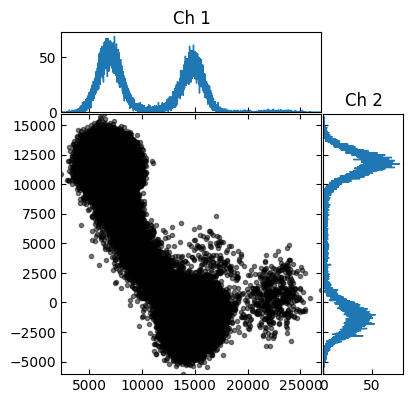

<Figure size 800x800 with 0 Axes>

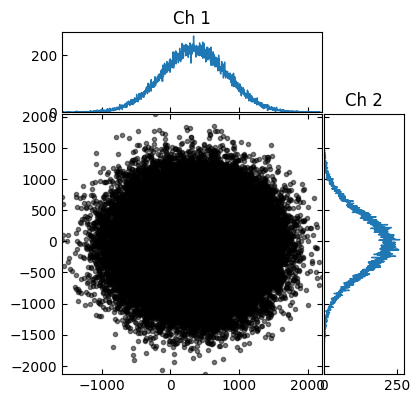

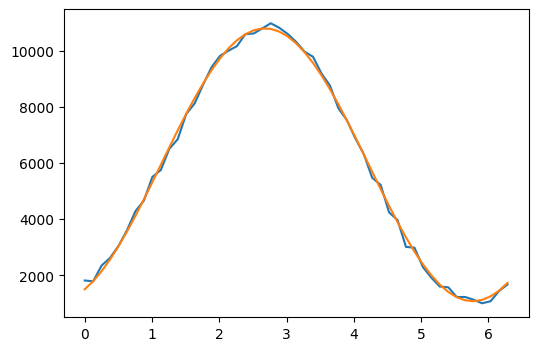



freq: 0.1617363839897276
 amp: -4853.354836618166
phase: -98.53882280837134
offset: 5937.415007598255


In [7]:
num_steps=51
reps=2000
RO_ram_amp=0.0
buffer = 1000
times = np.linspace(0, 2 * np.pi, num_steps)
values= ramsey_quantum_efficiency(q2, q1, general_vals_dict,num_steps, reps,RO_ram_amp,buffer)
I=values.rec_avg_vs_pats_1[0]
Q=values.rec_avg_vs_pats_1[1]
Qrange = np.ptp(Q)  # peak-to-peak range
Irange = np.ptp(I)
if Qrange > Irange:
    fit_data = Q
else:
    fit_data = I


fit_vals,_,_,_ = analysis.fit_sine(times,fit_data,guess_vals=[.16 ,100,-67.76128980276253,-263.4006117568909])

In [9]:
RO_ram_amp_start =0
RO_ram_amp_stop = .1
RO_ram_amp_steps = 21
RO_ram_ro_amp = np.linspace(RO_ram_amp_start, RO_ram_amp_stop,RO_ram_amp_steps)
ramsey_I, ramsey_Q = sweep_ramsey_quantum_efficiency(RO_ram_amp_start,RO_ram_amp_stop,RO_ram_amp_steps)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 51
Records per pattern: 2000
Buffers per acquistion: 34
DAQ samples per pattern: 8192
0, No error
Capturing 34 buffers. Press <enter> to abort
Capture completed in 17.626740 sec
Captured 34 buffers (1.928888 buffers per sec)
Captured 104448 records (5925.542677 records per sec)
Transferred 1711276032 bytes (97084091.219314 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch

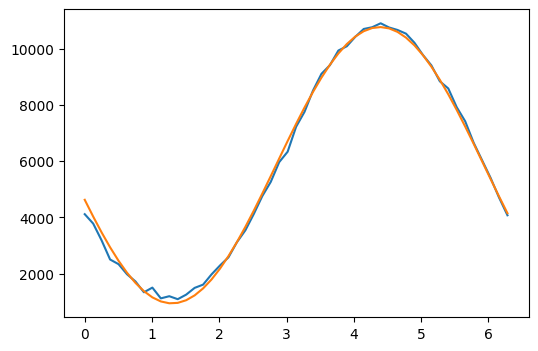



 amp: -4914.28924989241
phase: -24.879835724843904
offset: 5855.994179623094
Index 0: Amp=-4914.28925 (Q)


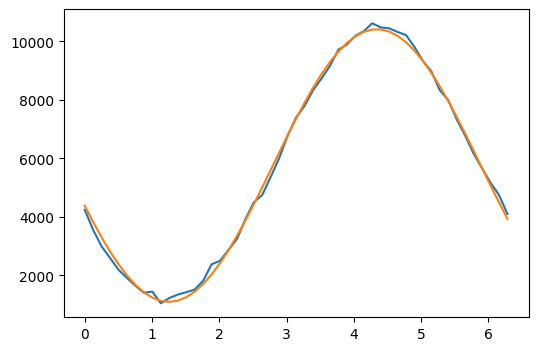



 amp: 4661.072419188444
phase: -27.974369090862485
offset: 5755.554736860094
Index 1: Amp=4661.07242 (Q)


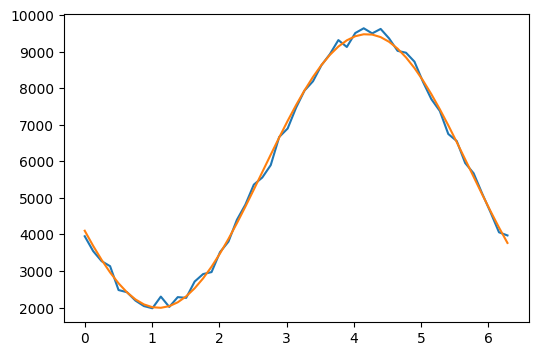



 amp: -3742.0484686809395
phase: -37.24747074108013
offset: 5734.972098783051
Index 2: Amp=-3742.04847 (Q)


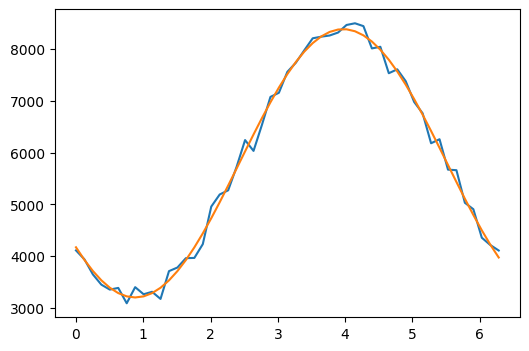



 amp: -2593.6372953578943
phase: -49.58904634330639
offset: 5792.470353074533
Index 3: Amp=-2593.63730 (Q)


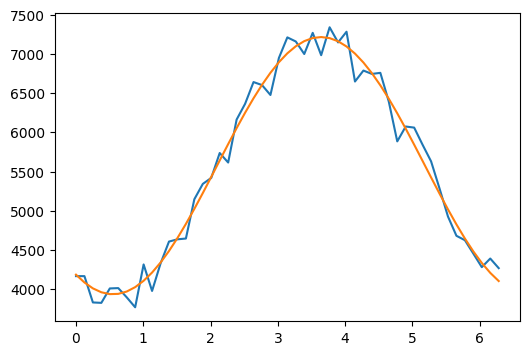



 amp: -1642.0693120760964
phase: -61.820618135960466
offset: 5574.8976624470915
Index 4: Amp=-1642.06931 (Q)


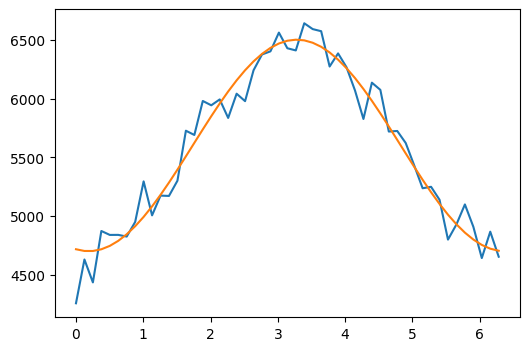



 amp: -901.0312105785308
phase: -67.73680548609751
offset: 5600.935576986779
Index 5: Amp=-901.03121 (Q)


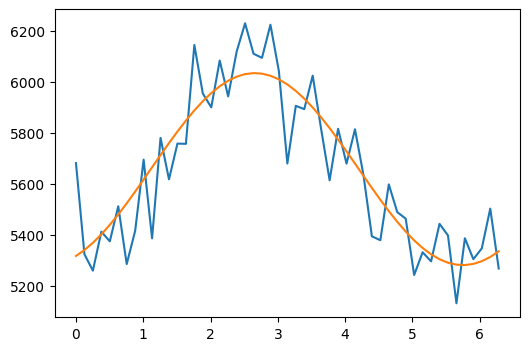



 amp: 377.3026166844566
phase: -70.2453909916475
offset: 5657.645019693053
Index 6: Amp=377.30262 (Q)


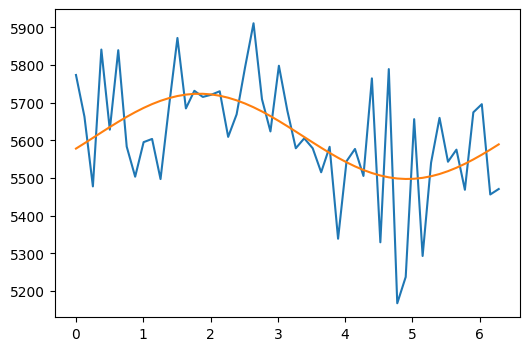



 amp: 113.24267246240822
phase: -63.12299437111748
offset: 5610.788112045078
Index 7: Amp=113.24267 (Q)


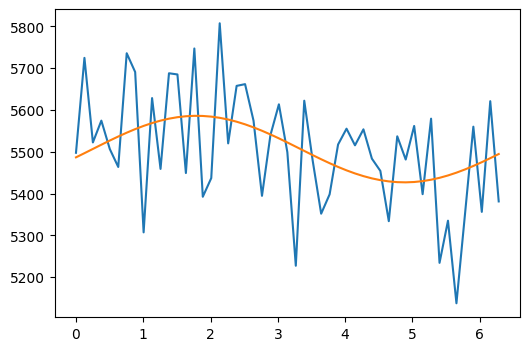



 amp: 79.5927439415954
phase: -50.51663624098497
offset: 5506.582359700677
Index 8: Amp=79.59274 (Q)


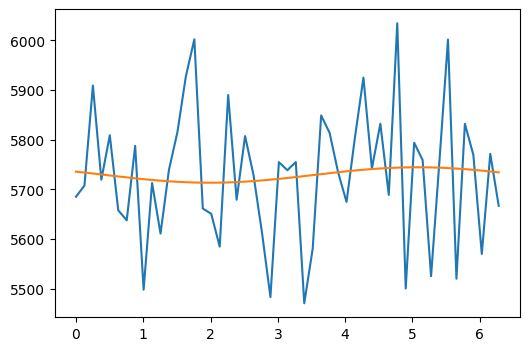



 amp: 15.540382296606946
phase: -66.42372061094046
offset: 5728.906423844825
Index 9: Amp=15.54038 (Q)


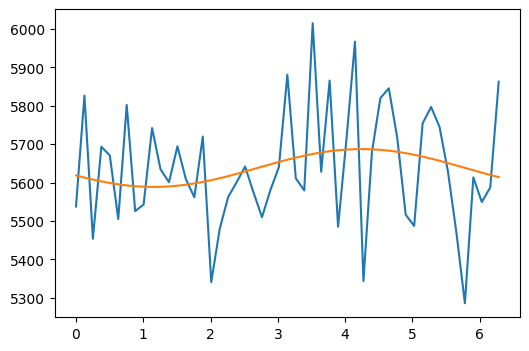



 amp: -49.33023611427618
phase: -68.7136574964809
offset: 5637.906374020119
Index 10: Amp=-49.33024 (Q)


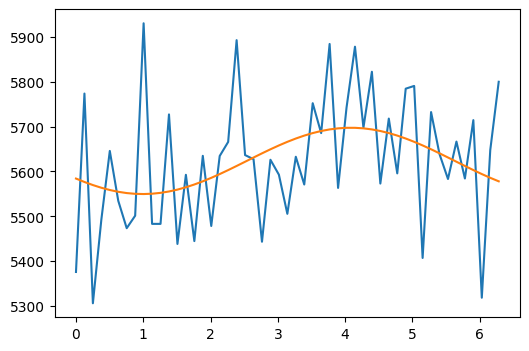



 amp: -73.86499222030778
phase: -68.55330316548368
offset: 5623.630916720993
Index 11: Amp=-73.86499 (Q)


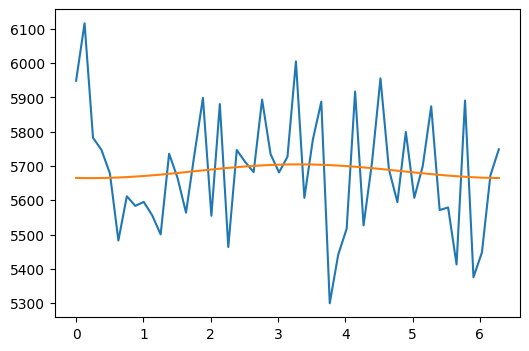



 amp: -20.026718178623153
phase: -67.76276442520674
offset: 5684.706467649603
Index 12: Amp=-20.02672 (Q)


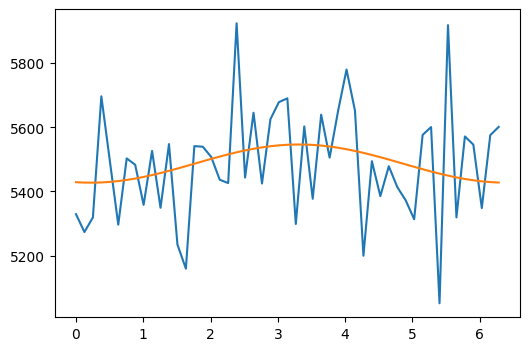



 amp: -59.5468083496306
phase: -67.76883561420232
offset: 5486.810925879103
Index 13: Amp=-59.54681 (Q)


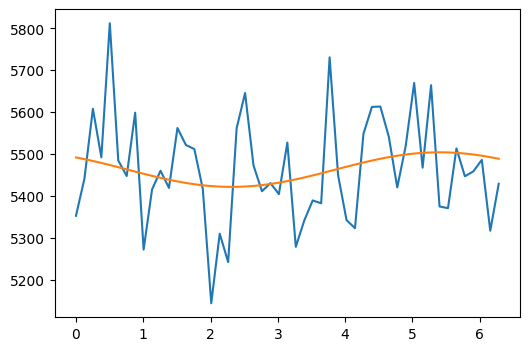



 amp: 41.287094926314815
phase: -66.75189028174734
offset: 5462.834363123686
Index 14: Amp=41.28709 (Q)


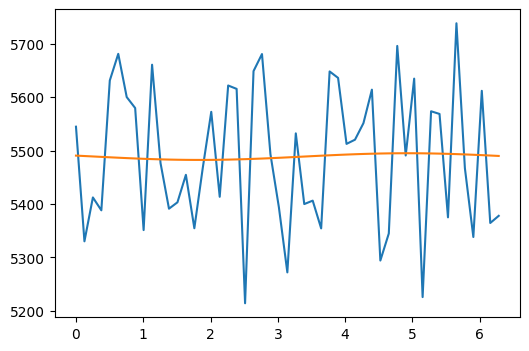



 amp: 6.260392226734368
phase: -47.41827952874131
offset: 5488.839756253689
Index 15: Amp=6.26039 (Q)


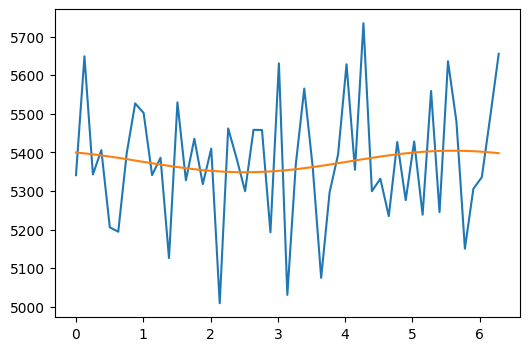



 amp: 27.83856849127205
phase: -66.95552446010532
offset: 5376.508622699533
Index 16: Amp=27.83857 (Q)


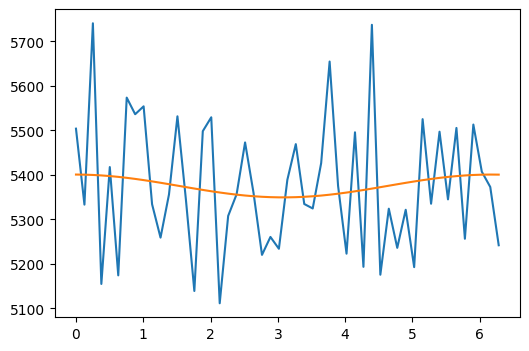



 amp: 25.64049580027217
phase: -67.53440443420736
offset: 5375.307639447939
Index 17: Amp=25.64050 (Q)


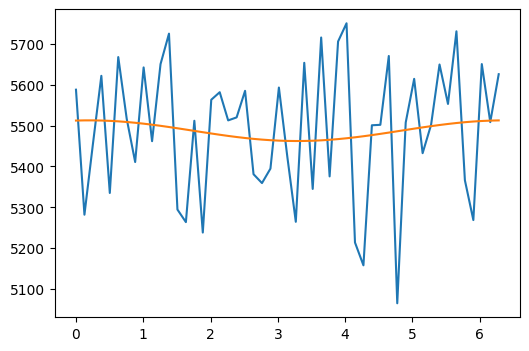



 amp: 25.272269589670465
phase: -67.74136310191207
offset: 5487.5197096106795
Index 18: Amp=25.27227 (Q)


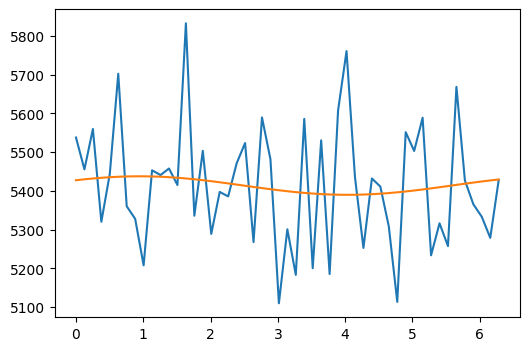



 amp: 23.90064903264545
phase: -68.50533211252473
offset: 5413.910753589481
Index 19: Amp=23.90065 (Q)


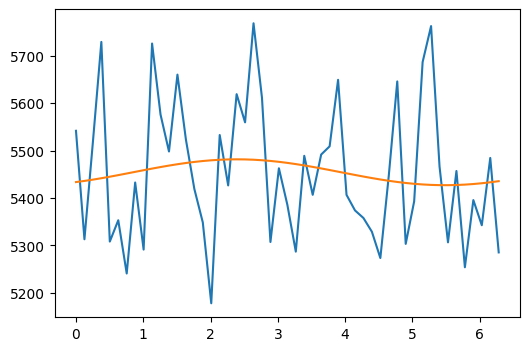



 amp: -27.23797122374374
phase: -66.83579709958666
offset: 5454.253050530101
Index 20: Amp=-27.23797 (Q)


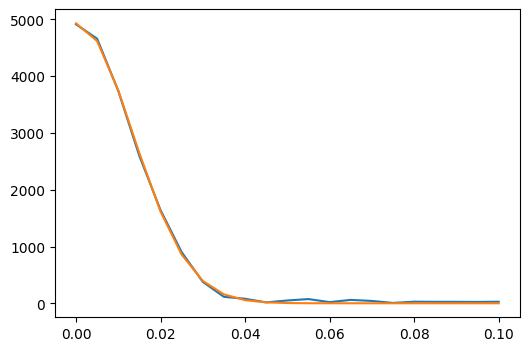



   amp: 163.93485229863361
 mu: 0.0001933924646139396
sigma: 0.0132577893347446


Text(0.5, 1.0, 'Ramsey Amplitude vs RO_ram_amp')

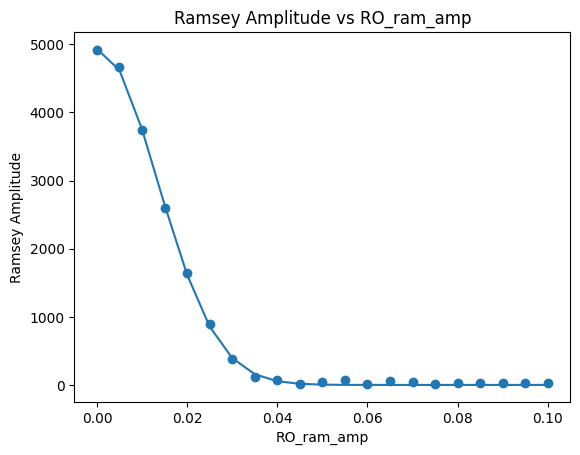

In [10]:
times = np.linspace(0, 2 * np.pi, num_steps)
fixed_freq=0.1617363839897276
ramsey_amp=fit_ramsey_amplitude(times, ramsey_I, ramsey_Q, fixed_freq) 
Gaussian_fit_vals,_,y_vals,_ = analysis.fit_gaussian_points(RO_ram_ro_amp,ramsey_amp,guess_vals=[300,0,1])
plt.scatter(RO_ram_ro_amp,ramsey_amp)
plt.plot(RO_ram_ro_amp, y_vals)
plt.xlabel("RO_ram_amp")
plt.ylabel("Ramsey Amplitude")
plt.title("Ramsey Amplitude vs RO_ram_amp")


In [11]:
0.5*(25.16400447220609**2)*( 0.0132577893347446**2)

0.05565084197089064

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 8.638406 sec
Captured 15 buffers (1.736431 buffers per sec)
Captured 46080 records (53

<Figure size 800x800 with 0 Axes>

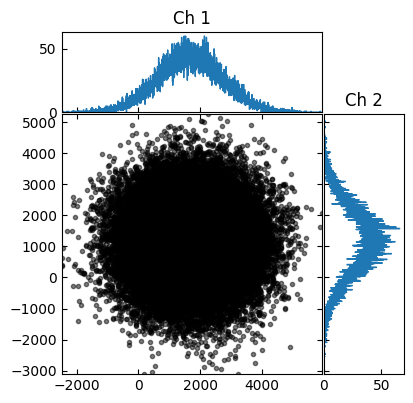

<Figure size 800x800 with 0 Axes>

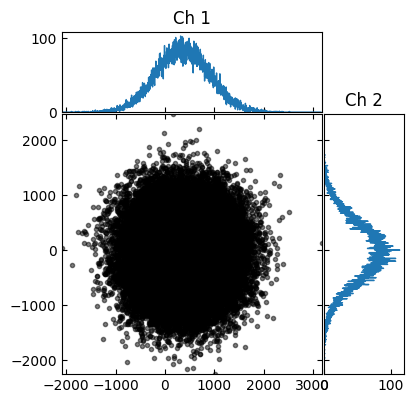

I histogram


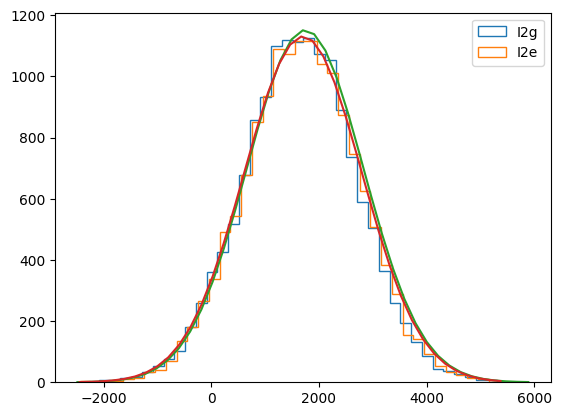

Q histogram


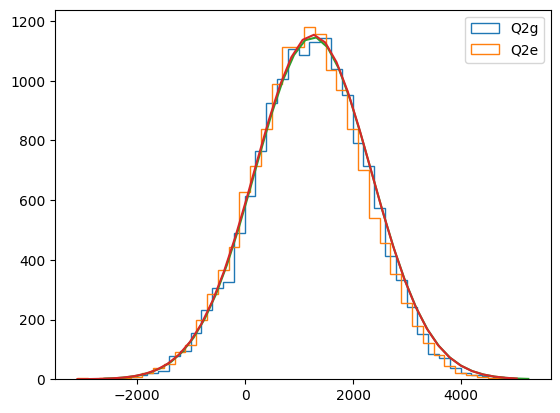

SNR: 0.03633445218449579
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.469495 sec
Captured 15 buffers (2.008168 buffers per sec)
C

<Figure size 800x800 with 0 Axes>

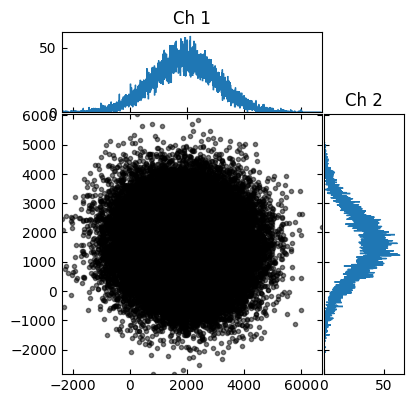

<Figure size 800x800 with 0 Axes>

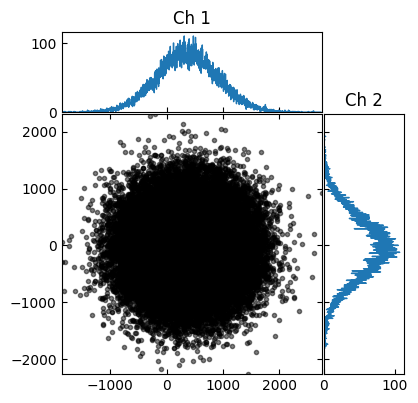

I histogram


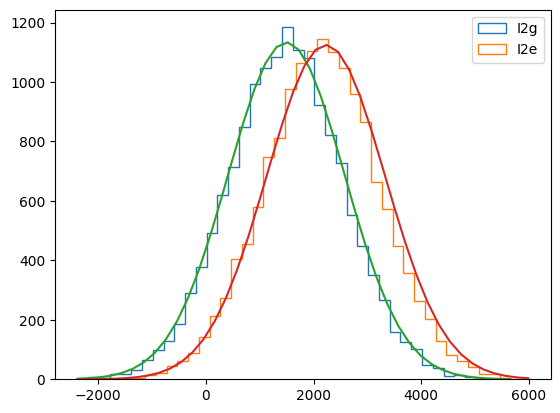

Q histogram


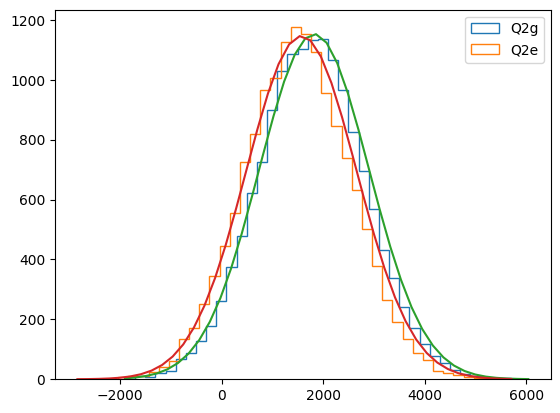

SNR: 0.710916374455328
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.024071 sec
Captured 15 buffers (2.135514 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

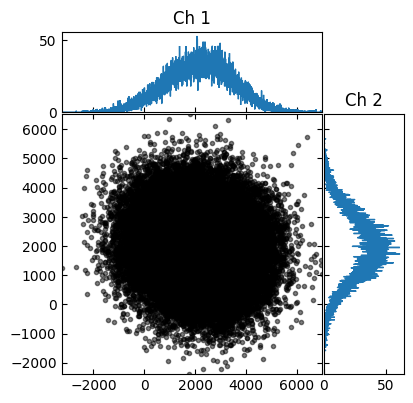

<Figure size 800x800 with 0 Axes>

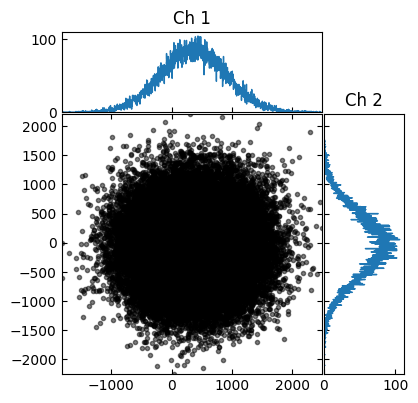

I histogram


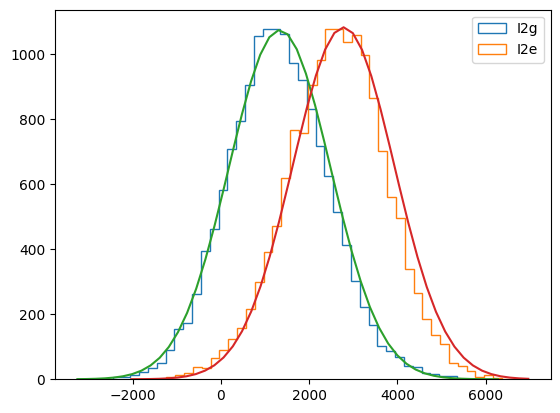

Q histogram


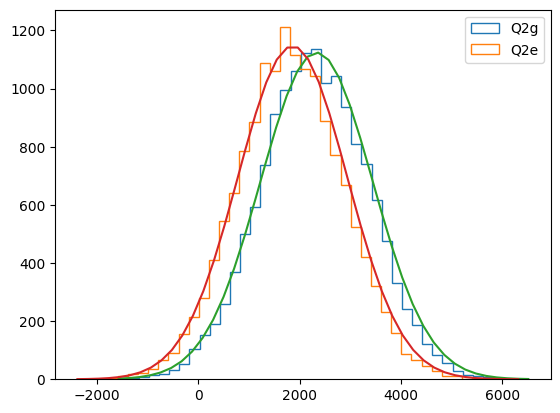

SNR: 1.3556300672015167
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 6.936024 sec
Captured 15 buffers (2.162622 buffers per sec)
Ca

<Figure size 800x800 with 0 Axes>

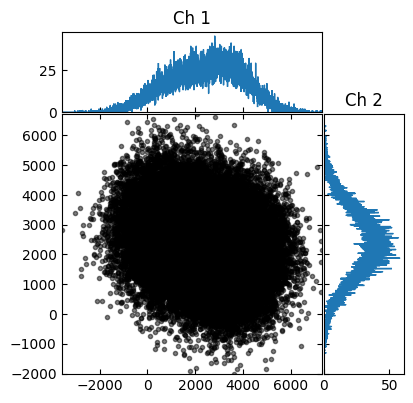

<Figure size 800x800 with 0 Axes>

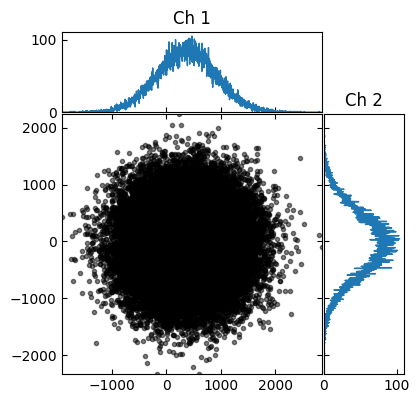

I histogram


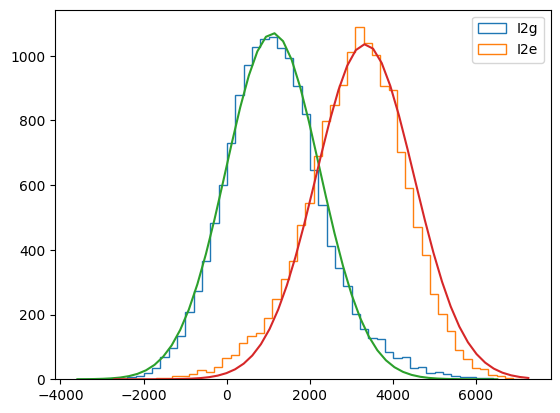

Q histogram


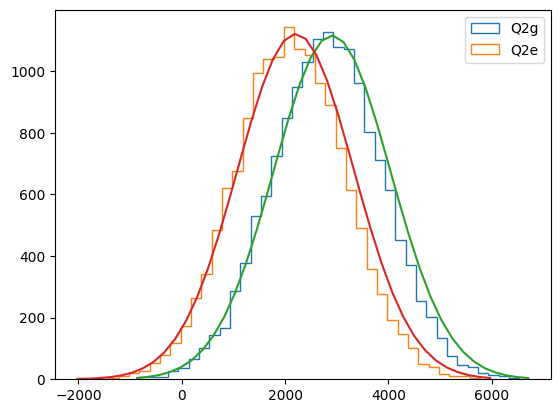

SNR: 2.039797263622012
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.050280 sec
Captured 15 buffers (2.127575 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

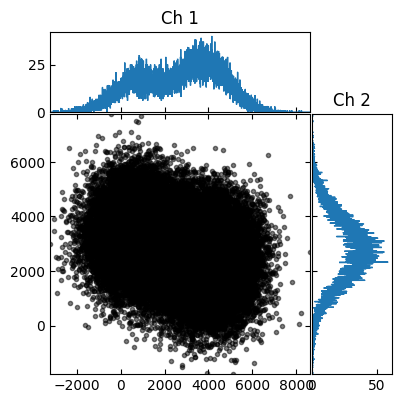

<Figure size 800x800 with 0 Axes>

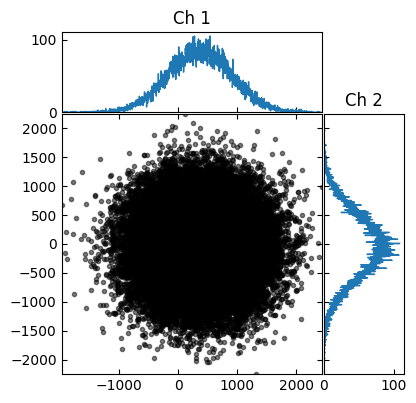

I histogram


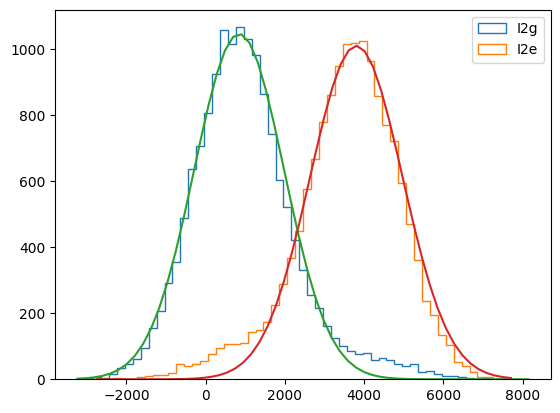

Q histogram


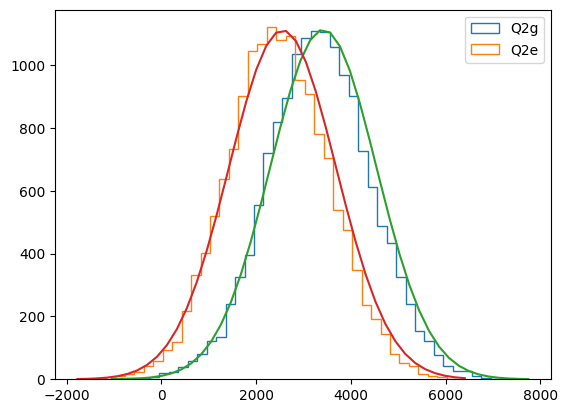

SNR: 2.705040021490694
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 8.483954 sec
Captured 15 buffers (1.768044 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

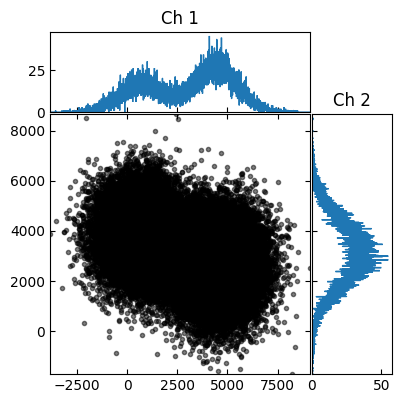

<Figure size 800x800 with 0 Axes>

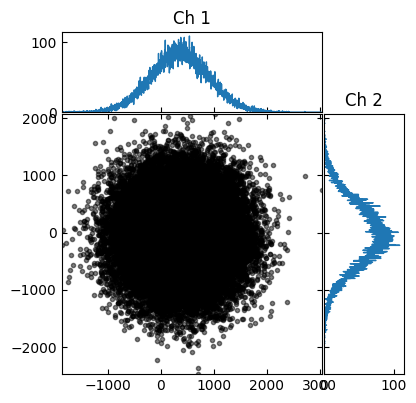

I histogram


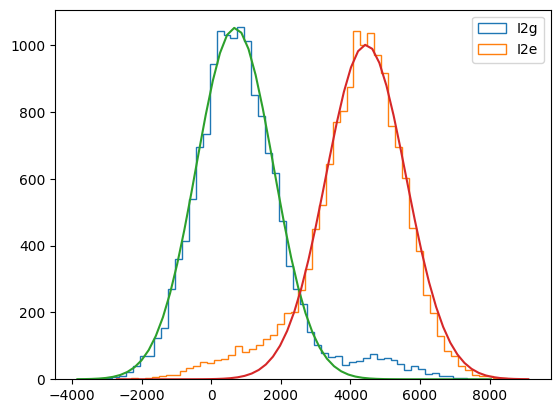

Q histogram


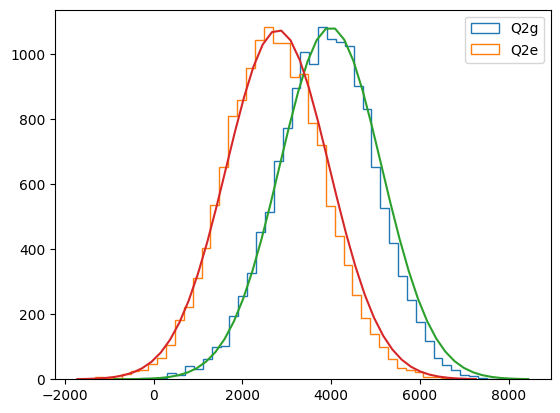

SNR: 3.455712059096446
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.106545 sec
Captured 15 buffers (2.110730 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

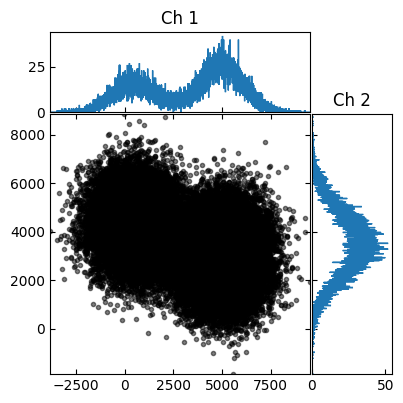

<Figure size 800x800 with 0 Axes>

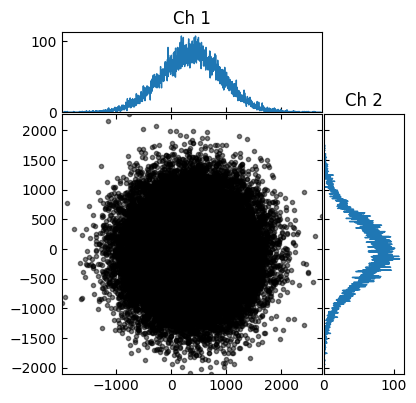

I histogram


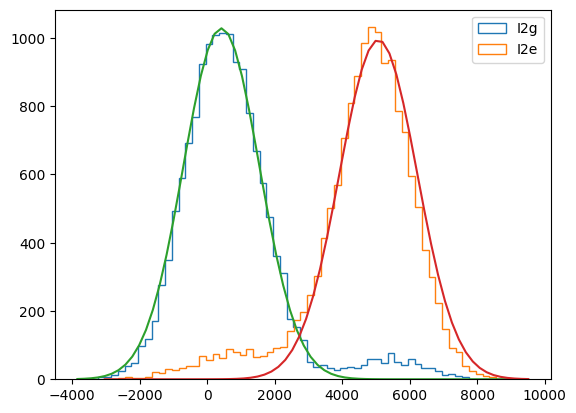

Q histogram


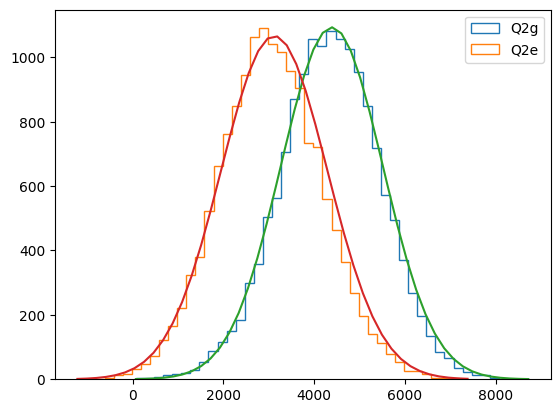

SNR: 4.213047122436119
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.926460 sec
Captured 15 buffers (1.892396 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

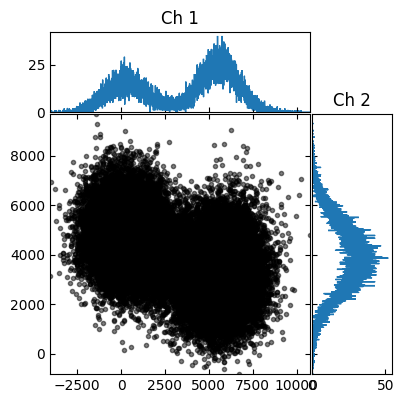

<Figure size 800x800 with 0 Axes>

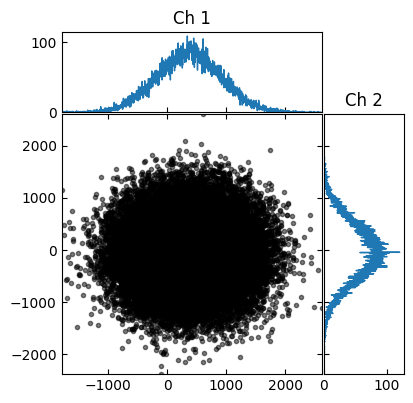

I histogram


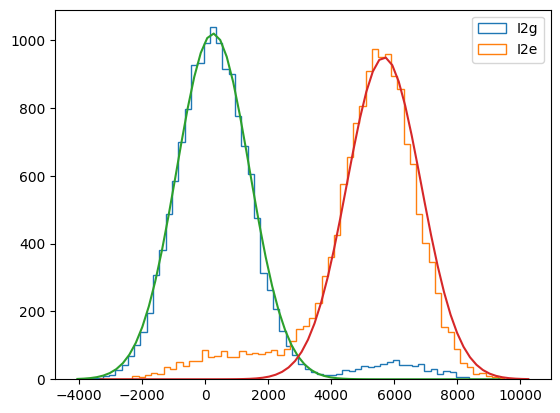

Q histogram


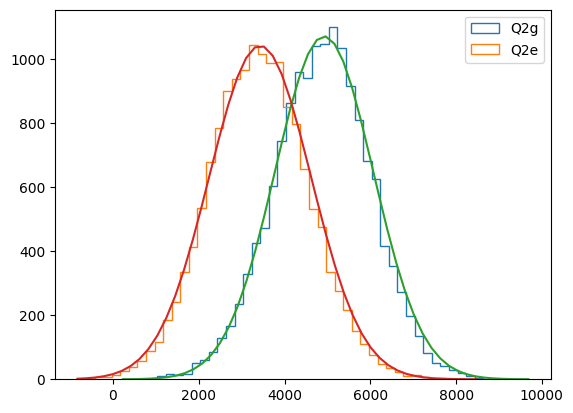

SNR: 4.81666673001346
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.337006 sec
Captured 15 buffers (2.044431 buffers per sec)
Capt

<Figure size 800x800 with 0 Axes>

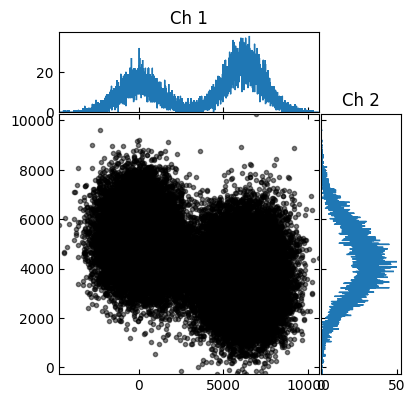

<Figure size 800x800 with 0 Axes>

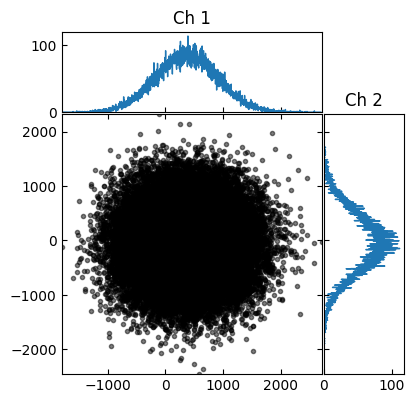

I histogram


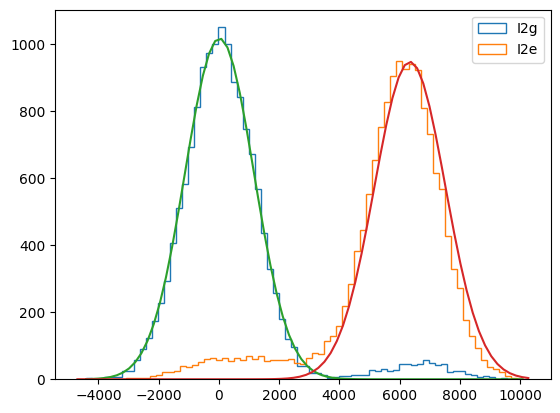

Q histogram


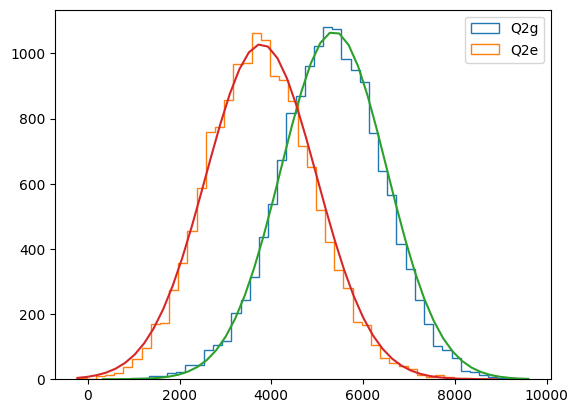

SNR: 5.570843303259538
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.132371 sec
Captured 15 buffers (2.103087 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

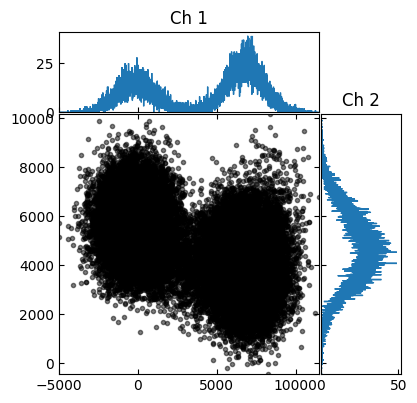

<Figure size 800x800 with 0 Axes>

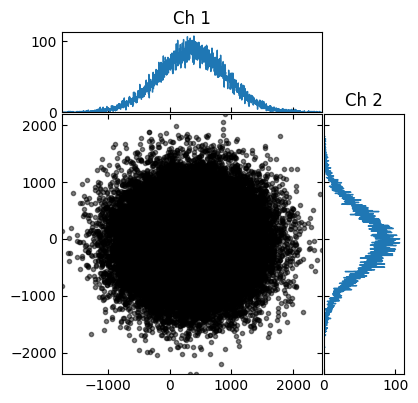

I histogram


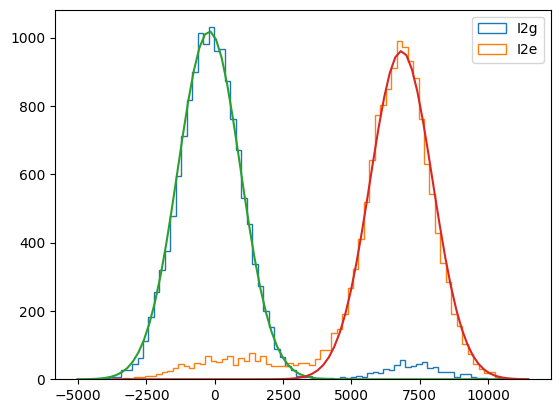

Q histogram


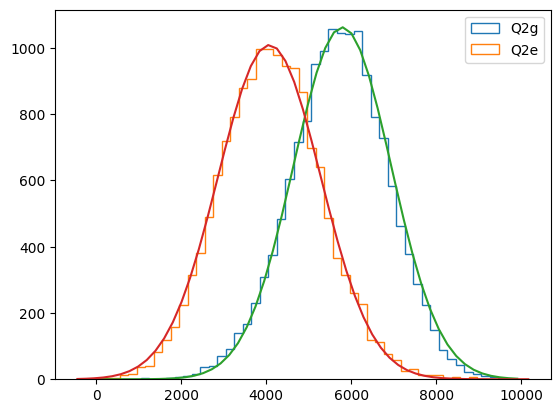

SNR: 6.238229874147438
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.179224 sec
Captured 15 buffers (2.089362 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

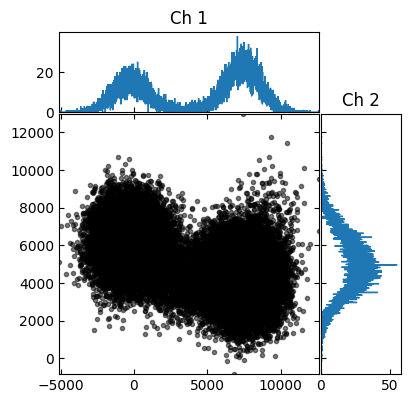

<Figure size 800x800 with 0 Axes>

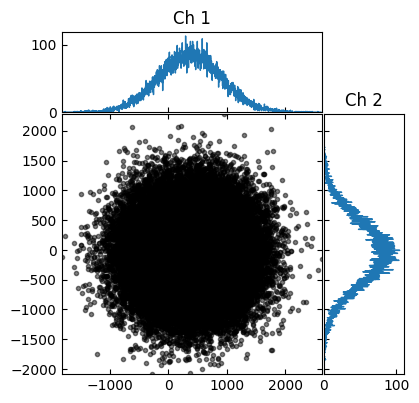

I histogram


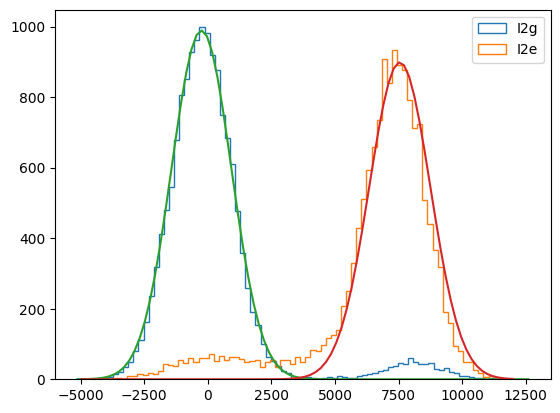

Q histogram


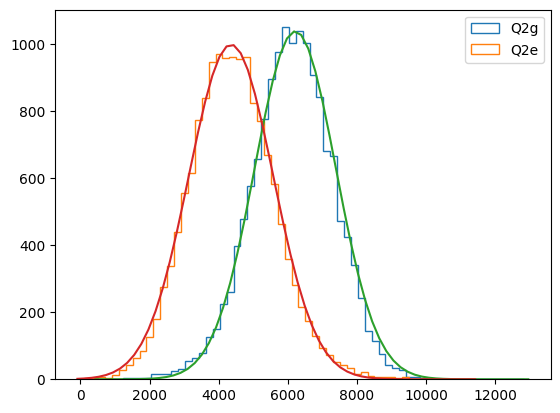

SNR: 6.713259856282626
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.223189 sec
Captured 15 buffers (2.076645 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

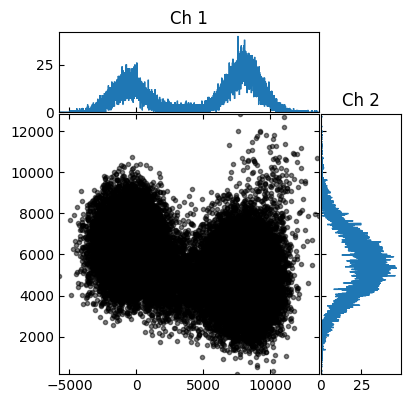

<Figure size 800x800 with 0 Axes>

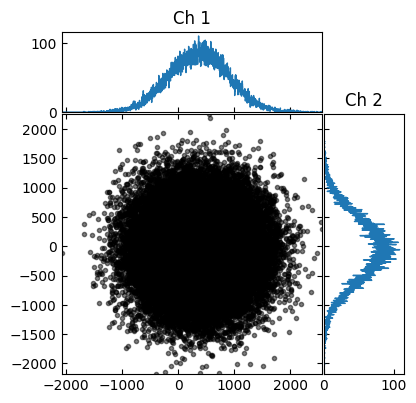

I histogram


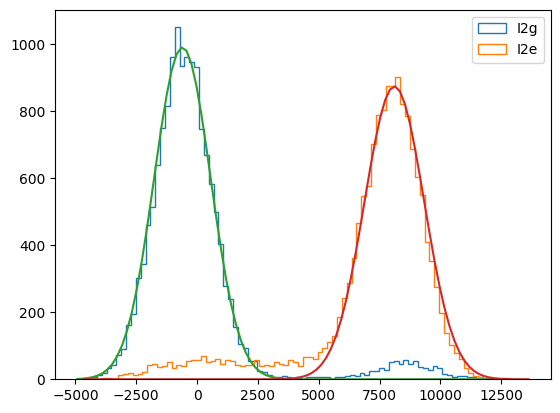

Q histogram


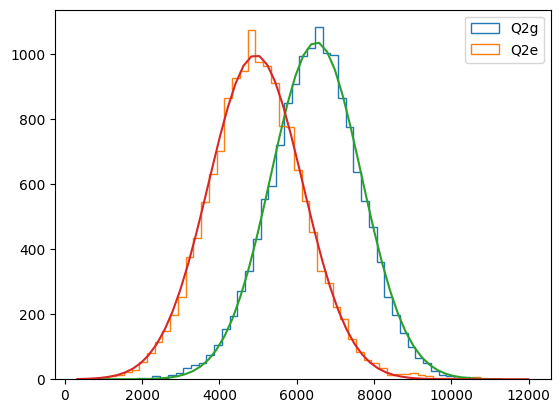

SNR: 7.423290343060893
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.578013 sec
Captured 15 buffers (1.979411 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

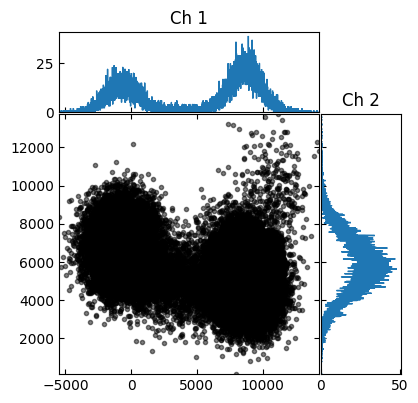

<Figure size 800x800 with 0 Axes>

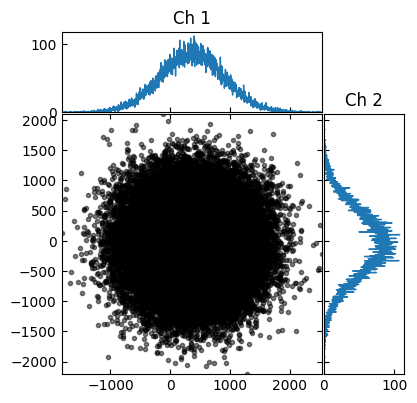

I histogram


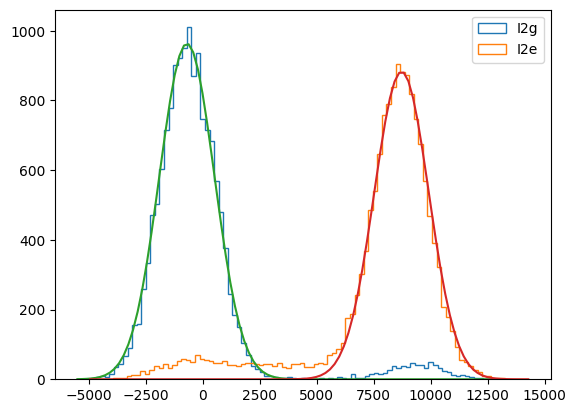

Q histogram


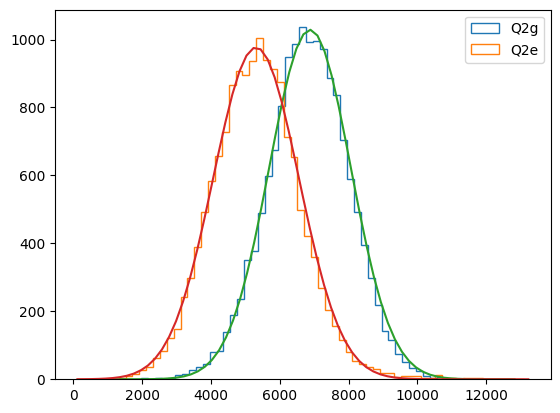

SNR: 7.894462259522062
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.653286 sec
Captured 15 buffers (1.959943 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

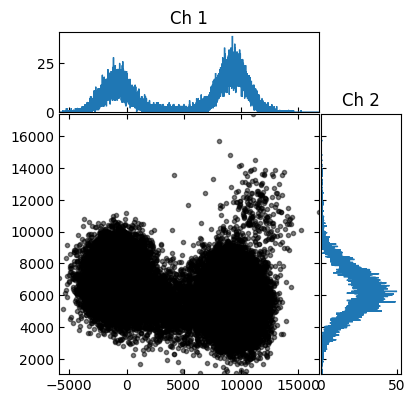

<Figure size 800x800 with 0 Axes>

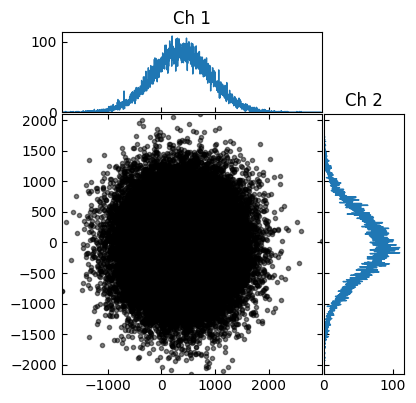

I histogram


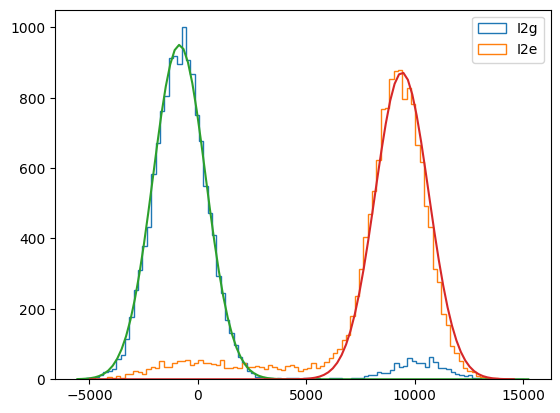

Q histogram


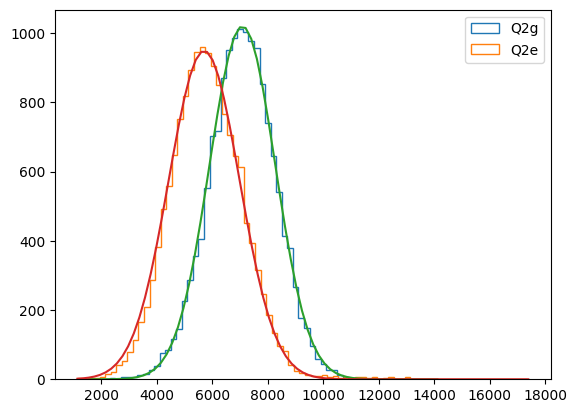

SNR: 8.432432839738896
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.710477 sec
Captured 15 buffers (1.945405 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

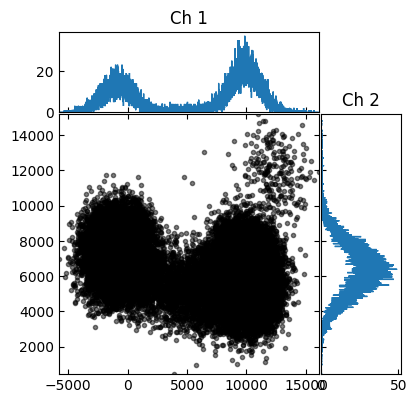

<Figure size 800x800 with 0 Axes>

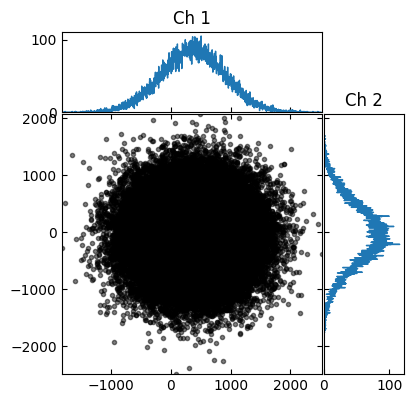

I histogram


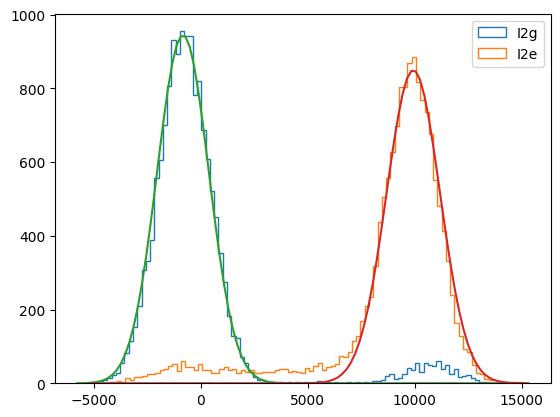

Q histogram


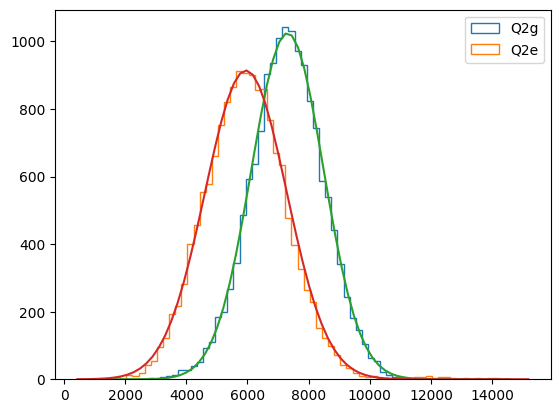

SNR: 8.724508648365662
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.246557 sec
Captured 15 buffers (2.069949 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

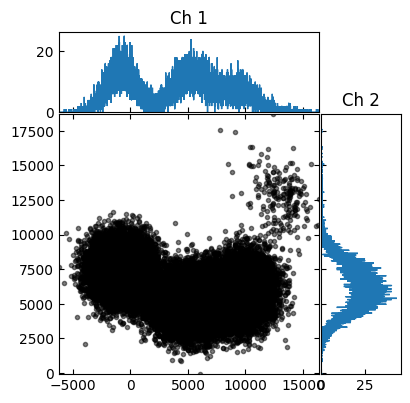

<Figure size 800x800 with 0 Axes>

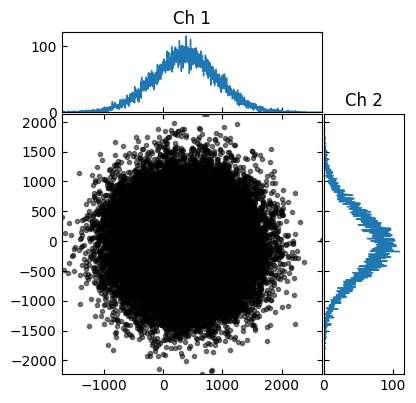

I histogram


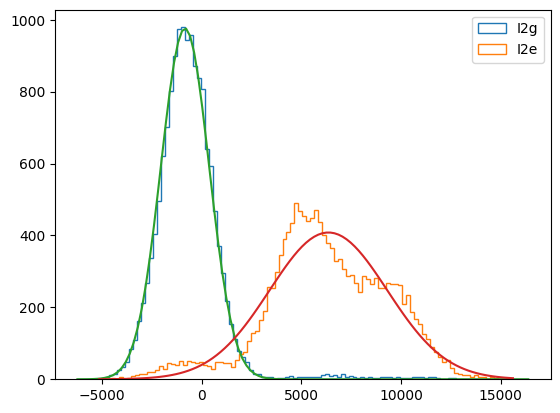

Q histogram


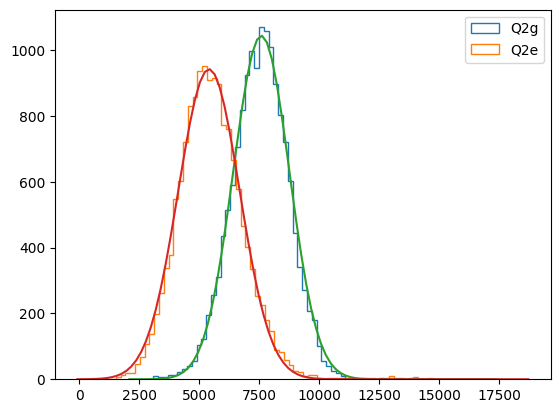

SNR: 4.547545712000154
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.839831 sec
Captured 15 buffers (1.913306 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

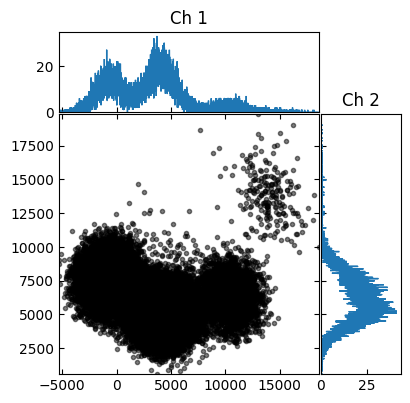

<Figure size 800x800 with 0 Axes>

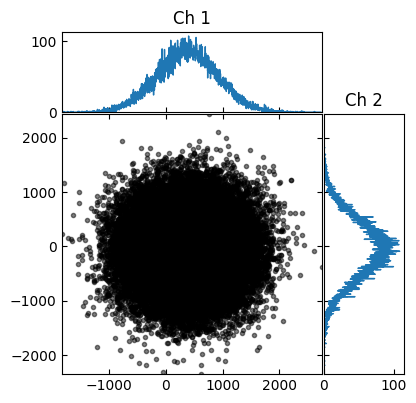

I histogram


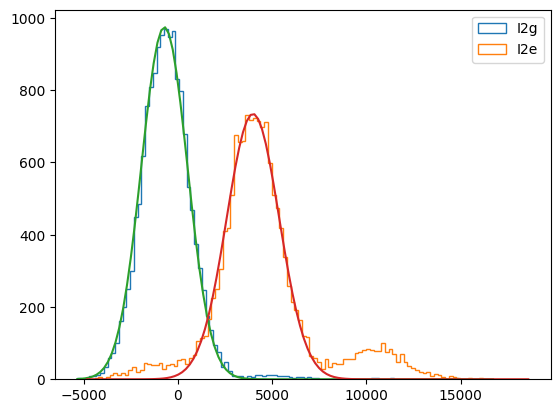

Q histogram


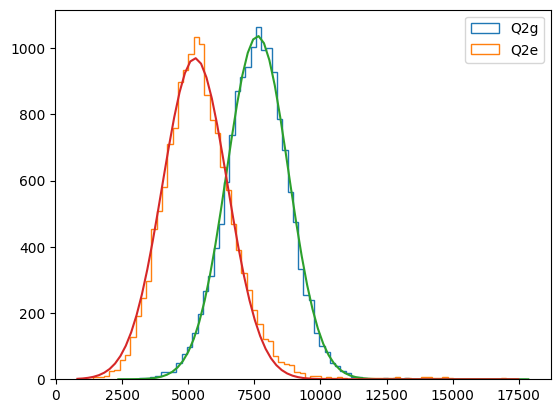

SNR: 4.198625888836473
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.548028 sec
Captured 15 buffers (1.987274 buffers per sec)
Cap

<Figure size 800x800 with 0 Axes>

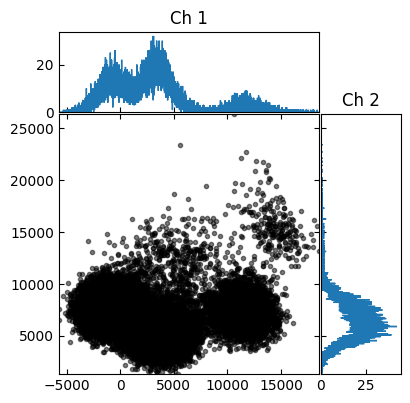

<Figure size 800x800 with 0 Axes>

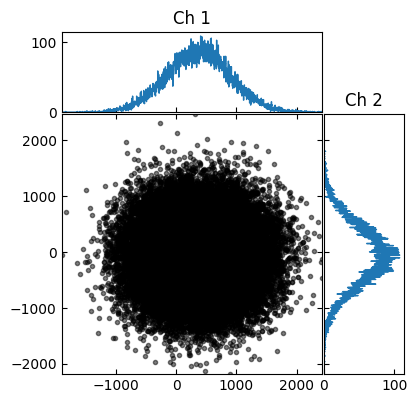

I histogram


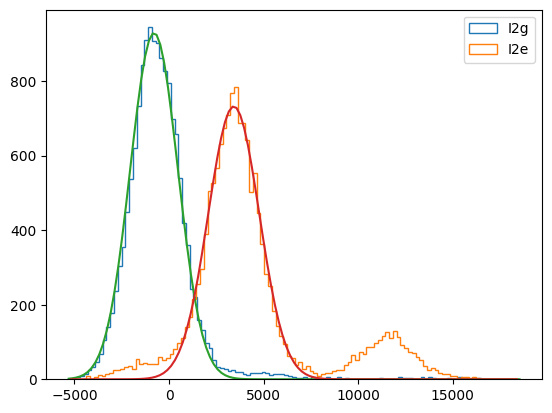

Q histogram


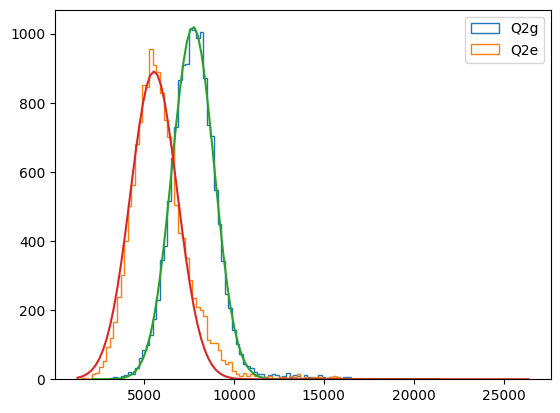

SNR: 3.7332375157794453
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.542220 sec
Captured 15 buffers (1.988804 buffers per sec)
Ca

<Figure size 800x800 with 0 Axes>

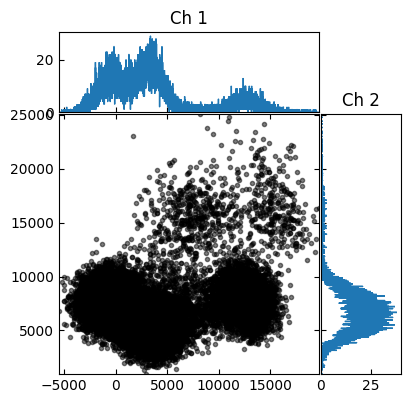

<Figure size 800x800 with 0 Axes>

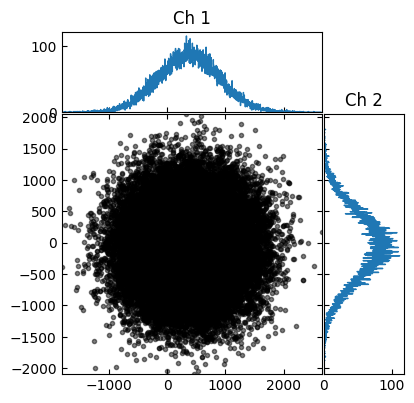

I histogram


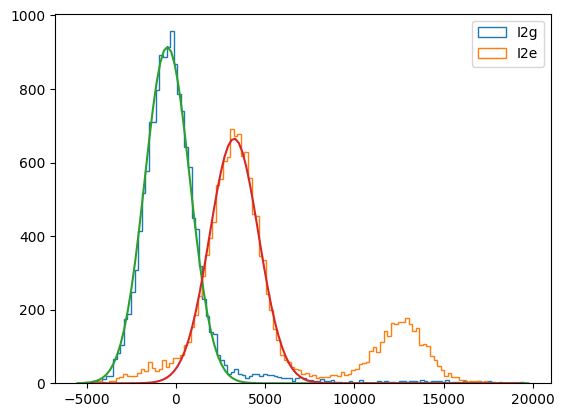

Q histogram


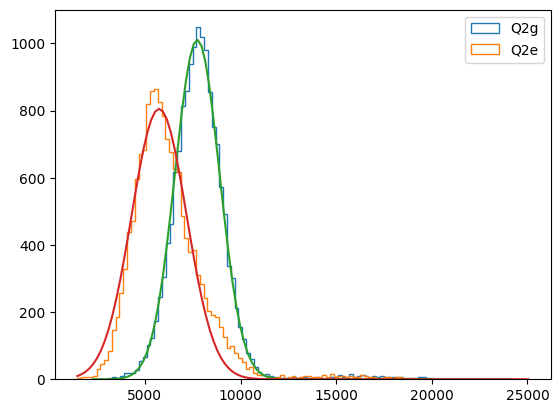

SNR: 3.2388038570131306
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.090466 sec
Captured 15 buffers (2.115517 buffers per sec)
Ca

<Figure size 800x800 with 0 Axes>

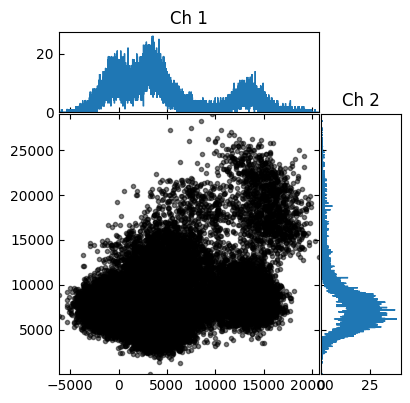

<Figure size 800x800 with 0 Axes>

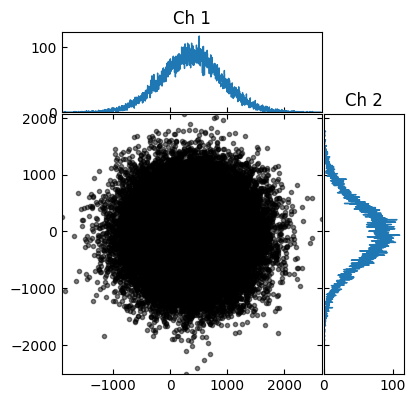

I histogram


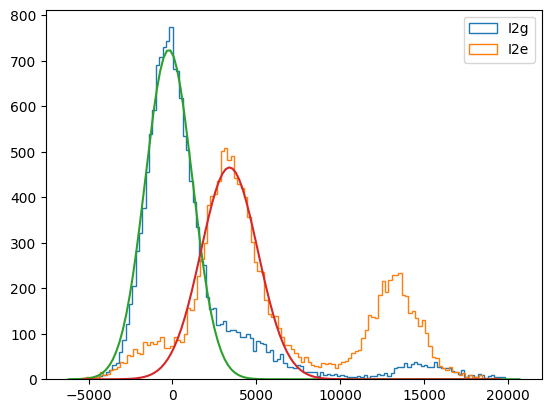

Q histogram


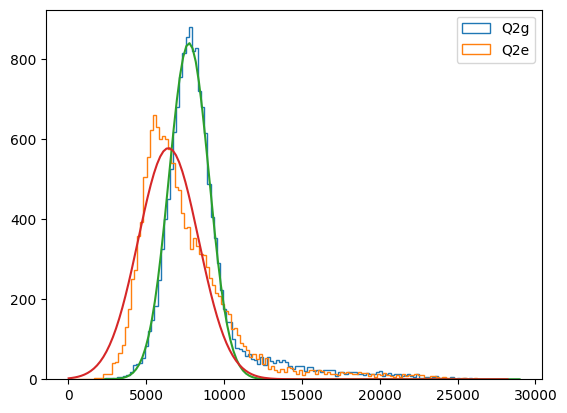

SNR: 2.4368686824310783
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 7.635079 sec
Captured 15 buffers (1.964616 buffers per sec)
Ca

<Figure size 800x800 with 0 Axes>

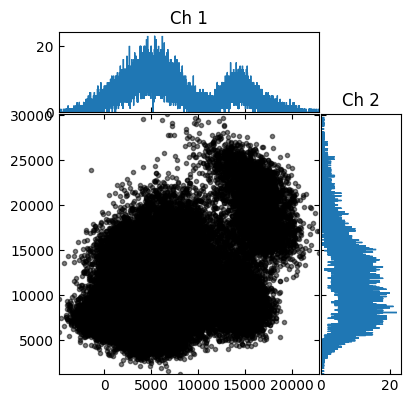

<Figure size 800x800 with 0 Axes>

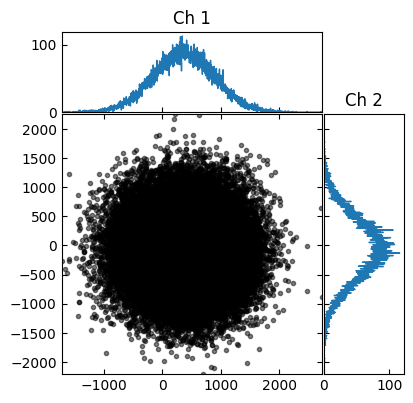

I histogram


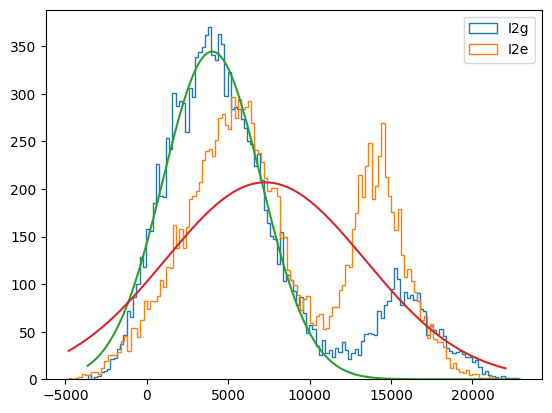

Q histogram


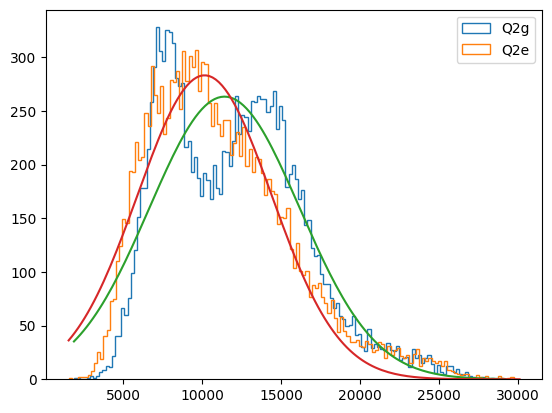

SNR: 0.7699585283597937


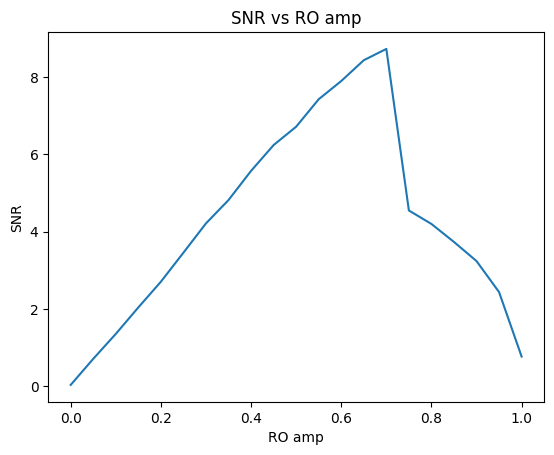

In [12]:
amp_start = 0
amp_stop = 1
amp_steps=21
amp_list = np.linspace(amp_start, amp_stop, amp_steps)
SNR_list = sweep_ro_amp(amp_list)
plt.plot(amp_list, SNR_list)
plt.xlabel("RO amp")
plt.ylabel("SNR")
plt.title("SNR vs RO amp")
plt.show()
# freq_start = 6.6550
# freq_stop = 6.6560
# freq_steps=21
# freq_list = np.linspace(freq_start, freq_stop, freq_steps)
# SNR_list = sweep_ro_freq(freq_list)
# plt.plot(freq_list, SNR_list)
# plt.xlabel("RO Frequency (GHz)")
# plt.ylabel("SNR")
# plt.title("SNR vs RO Frequency")
# plt.show()

# num_steps=3
# reps=15000
# q2.ROIF = 6.65-readout_dict["RO_LO"]
# q2.ro_amp=0.5

# SNR= get_snr(q2, q1, general_vals_dict, num_steps, reps)

In [9]:
# max_idx = np.argmax(SNR_list)
# max_freq = amp_list[max_idx]
# max_snr = SNR_list[max_idx]

# print(f"Maximum SNR: {max_snr:.5f} at frequency: {max_freq:.6f} GHz")

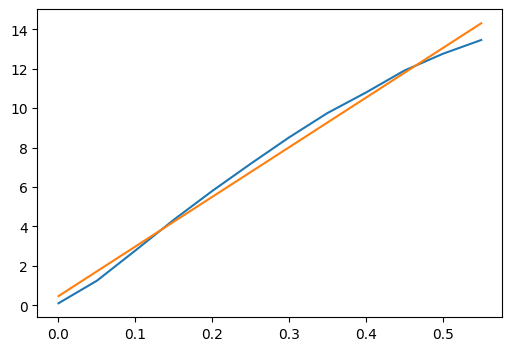



m: 25.16400447220609
b: 0.46786521440705925


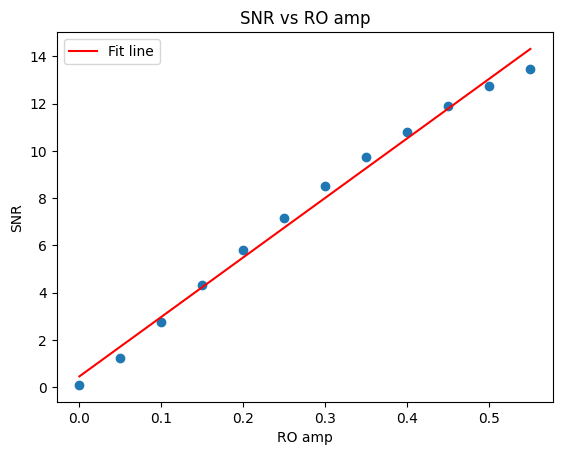

In [9]:
amp_list = np.array(amp_list)
SNR_list = np.array(SNR_list)

mask = amp_list < 0.6
amp_fit = amp_list[mask]
SNR_fit = SNR_list[mask]
(popt, perr, y_vals_fit, pcov)=analysis.fit_line(amp_fit,SNR_fit)  
plt.scatter(amp_fit, SNR_fit)  
plt.plot(amp_fit, y_vals_fit, color='red', label='Fit line')
plt.xlabel("RO amp")
plt.ylabel("SNR")
plt.title("SNR vs RO amp")
plt.legend()